## Projet de Python pour le data scientist (2021-2022)
## "Prédire la gravité des accidents corporels de la route"
### DUJARDIN Thomas, RONDEY Hélène, ROSUNEE Avichaï

<a href="https://colab.research.google.com/github/helene-78/Accidents/blob/main/prep_df_utiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation et chargement des modules

In [1]:
#!pip install imblearn
#!pip install plotly
#!pip install haversine
# !pip install statsmodels #statsmodels, pour utiliser le module de séries temp SARIMAX
#!pip install keras
#!pip install tensorflow
#!pip install dash
#!pip install folium

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns #Tableau des corrélations
from datetime import date


from imblearn.over_sampling import SMOTE # Pour avoir 50 % de 0 et 50 % de 1 dans la colonne presence_accident
from sklearn.linear_model import LogisticRegression # Regression logistique
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold #KFold répété, pour mieux entraîner le modèle
from sklearn.model_selection import train_test_split


from sklearn import model_selection # Pour utiliser RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier #
from sklearn.model_selection import cross_val_score #Pour mesurer la précision de l'algorithme
from sklearn.metrics import classification_report, confusion_matrix #
from sklearn.utils import shuffle # Pour que le scoring "roc_auc" fonctionne
from sklearn.preprocessing import label_binarize # Transformer y en variable catégorique
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


# ARIMA
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX = modèle de séries temporelles
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

# Carte
import folium
import  branca


#Réseau de neurones
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
import pickle # Pour sauvegarder le modèle de OneHotEncoding

#Interface Dash
import dash 
from dash import dcc # import dash_core_components as dcc # Pour utiliser dcc.Input (ce qui permet d'inclure les inputs dans le HTML)
from dash import html #import dash_html_components as html # L'interface Dash est en HTML
from dash.dependencies import Input, Output, State, MATCH, ALL # Pour les callbacks
import plotly.express as px # Pour faire des graphes dans l'interface Dash

## Fusion des bases, sélection et reformatage des variables

**Fusion des 4 dataframes de l'ONISR pour l'année 2019**

In [3]:
df_accidents = pd.read_csv('Bases de données/caracteristiques-2019.csv', sep=";")
df_usagers = pd.read_csv('Bases de données/usagers-2019.csv', sep=";")
df_lieux = pd.read_csv('Bases de données/lieux-2019.csv', sep=";")
df_vehicules = pd.read_csv('Bases de données/vehicules-2019.csv', sep=";")
df_merge = df_accidents.merge(df_usagers.merge(df_lieux.merge(df_vehicules))) #dataframe à traiter

Pour illustrer la richesse des informations de la base globale, on va afficher les premiers accidents, et en décrire un avec quelques colonnes venant de chaque base.

Vu que tous les usagers (conducteurs, passagers, piétons heurtés) sont reliés à un véhicule, on peut lire ci-dessous combien de personnes sont impliquées dans un accident donné. 

In [4]:
df_merge.groupby(['Num_Acc'] )['id_vehicule'].count()

Num_Acc
201900000001    3
201900000002    1
201900000003    4
201900000004    4
201900000005    3
               ..
201900058836    3
201900058837    3
201900058838    1
201900058839    1
201900058840    2
Name: id_vehicule, Length: 58840, dtype: int64

In [5]:
df_merge[["Num_Acc","id_vehicule", 'jour', 'vma' ,'choc', 'place', 'sexe', 'an_nais',"grav"]].head(8)

,Num_Acc,id_vehicule,jour,vma,choc,place,sexe,an_nais,grav
0,201900000001,138 306 524,30,70,5,2,2,2002,4
1,201900000001,138 306 524,30,70,5,1,2,1993,4
2,201900000001,138 306 525,30,70,3,1,1,1959,1
3,201900000002,138 306 523,30,70,1,1,2,1994,4
4,201900000003,138 306 520,28,90,1,1,1,1996,1
5,201900000003,138 306 520,28,90,1,2,2,1930,4
6,201900000003,138 306 521,28,90,4,1,1,1995,4
7,201900000003,138 306 522,28,90,4,1,1,1966,1


Par exemple, le premier accident de la base est numéroté 201900000001, a fait intervenir deux véhicules, identifiés par les numéros 138 306 524 et 138 306 525.

* **Rubrique Lieux** : L'accident a eu lieu le 30e jour du mois et dans une zone où la vitesse maximale autorisée était 70 km/h .
* **Rubrique Véhicules** :Le premier véhicule a subi un choc sur l'arrière droit et le deuxième sur l'avant gauche 
* **Rubrique Usagers** : Le premier véhicule contenait un conducteur et un  passager à l'avant, le deuxième juste le conducteur. Les occupants de la première voiture étaient des femmes (nées en 1993 et 2002), et le conducteur de la deuxième était un homme (né en 1959). Les deux femmes ont été légèrement blessées** , et l'homme était indemne. <br />
 Un blessé léger est défini par l'ONISR comme "une victime ayant fait l'objet de soins médicaux mais n'ayant pas été admise comme patient à l'hôpital plus de 24 heures". 

**Suppression des colonnes inutiles à l'analyse de données, et des NaN**

On a choisi d'éliminer les variables : 
- *Num_Acc*, *id_vehicule* et *num_veh* : l'identifiant des accidents et des véhicules étaient utiles pour l'illustration mais ne servent pas à l'explication de la gravité des accidents. <br />
<br />
- *com*: le numéro de commune (INSEE), car on utilisera les données de département, de longitude et de latitude pour travailler sur la localisation des accidents
- *adr*: l'adresse postale, pour la même raison que com
- *v1*, *v2* et *voie* : des indices désignant la route, idem <br />


- *lartpc* et *larrout* : la largeur du terre-plein central et de la chaussée, que l'on choisit de ne pas inclure dans l'étude
- *occutc*: le nombre d'occupants dans le transport en commun, car cela concerne peu d'accidents dans la base


In [6]:
df_utiles = df_merge.drop(axis=1, labels=['Num_Acc', 'com', 'adr', 'v1', 'id_vehicule', 'num_veh', 'lartpc', 'larrout', 'occutc', 'v2', 'voie'])
df_utiles = df_utiles.dropna()


**Recodage de plusieurs variables : heures et joursdes accidents, entrées de type alphanumérique, données géographiques, catégories de véhicules** 

In [7]:
#Recodage de la colonne "hrmn" pour exprimer l'heure des accidents en minutes
df_utiles["hrmn"] = pd.to_datetime(df_utiles["hrmn"], format='%H:%S')
df_utiles["hrmn"] = df_utiles["hrmn"].apply(lambda x: int(x.hour)*60 + int(x.minute))
df_utiles["hrmn"] = df_utiles["hrmn"].astype('int64')

In [8]:
#Formatage de la colonne "jour_format_normal" pour contenir la date au format standard dd/mm/yyyy
df_utiles["jour_format_normal"] = df_utiles["jour"].astype(str)+'/'+df_utiles["mois"].astype(str)+'/'+df_utiles["an"].astype(str)
df_utiles["jour_format_normal"] = pd.to_datetime(df_utiles["jour_format_normal"], format="%d/%m/%Y")
df_utiles["colonne_soustraction"] = date(df_utiles["an"].iloc[0], 1, 1) # Création d'une colonne remplie avec la date du 01/01/2019
df_utiles["colonne_soustraction"] = pd.to_datetime(df_utiles["colonne_soustraction"]) #Pour transformer en objet date 
df_utiles["nbre_j"] = df_utiles["jour_format_normal"] - df_utiles["colonne_soustraction"] # Permet d'obtenir une colonne contenant, pour chaque accident,
# Le nombre de jours écoulés depuis le 01/01/2019
def datification(x):
    return x.days # Permet d'obtenir l'entier contenu par l'objet "date" de Python
df_utiles["nbre_j"] = df_utiles["nbre_j"].apply(datification) #Maintenant nbre_j est une colonne d'entiers

In [9]:
#On remplace les codes des départements de la Corse par des int
df_utiles["dep"] = df_utiles["dep"].replace(["2B"], "999")
df_utiles["dep"] = df_utiles["dep"].replace(["2A"], "998")
df_utiles["dep"] = df_utiles["dep"].astype('int64')
#On remplace les actions du piéton non encodées par des chiffres
df_utiles["actp"] = df_utiles["actp"].replace(["A"], "14") 
df_utiles["actp"] = df_utiles["actp"].replace(["B"], "15")

In [10]:
# Pour avoir les coordonnées GPS en float, sinon plotly.express (px) ne peut pas les afficher sur la carte de France
df_utiles['lat'] = df_utiles['lat'].str.replace(',', '.').astype(float)
df_utiles['long'] = df_utiles['long'].str.replace(',', '.').astype(float)

In [11]:
# On recode catv pour regrouper les véhicules en un plus petit nombre de catégories:
# 1 : véhicules légers (VL, VU)
# 2 : Sans permis (< 125 cm3)
# 3 : Poids lourds
# 4 : transports en commun
# 5 : > 125 cm3

def func(x):
    if x in [7,10]:
        x=1; 
    elif (x in [1, 2, 3, 30, 31, 32, 50, 60, 80, 99, 35, 41, 42]):
        x=2; 
    elif (x in [13, 14, 15, 16, 17, 20, 21]) :
        x=3 
    elif (x in  [37, 38, 39, 40])  :
        x= 4 
    elif (x in [33, 34, 36, 43]) : #voir dans la description si on peut mettre un else à la place
        x= 5 
    return x

        
df_utiles['catv'] = df_utiles['catv'].apply(func)


**Recodage de la colonne "grav", qui vaudra 1 en cas d'accident mortel, 0 sinon**

La variable "grav" est catégorielle: Indemne, Tué (au moins un mort), Blessé hospitalisé (au moins un, sans aucun tué), Blessé léger (au moins un, sans aucun blessé hospitalisé ni mort). 
Pour étudier la gravité des accidents, on fait le choix de passer d'une variable catégorielle à une variable binaire : accident mortel  ou non. 

In [12]:
df_utiles["grav"] = df_utiles["grav"].apply(lambda x: int(x==2)) # On recode la colonne "grav" : tué = 1, blessé léger/hospitalisé/indemne = 0

In [13]:
# La dépendance de "grav" en "an_nais" (mortalité en fct de l'année de naissance) est a priori non linéaire, on utilise alors
# an_nais²

df_utiles['an_nais_carre'] = df_utiles['an_nais'].apply(lambda x: x*x)
df_utiles['an_nais_carre']

0         4008004
1         3972049
2         3837681
3         3976036
4         3984016
           ...   
132972    3952144
132973    3992004
132974    3916441
132975    3896676
132976    3884841
Name: an_nais_carre, Length: 132977, dtype: int64

In [14]:
df_utiles.to_csv('df_utiles.csv')

In [15]:
df_utiles.head()

,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,...,catv,obs,obsm,choc,manv,motor,jour_format_normal,colonne_soustraction,nbre_j,an_nais_carre
0,30,11,2019,60,4,93,1,1,1,2,...,1,0,2,5,23,1,2019-11-30,2019-01-01,333,4008004
1,30,11,2019,60,4,93,1,1,1,2,...,1,0,2,5,23,1,2019-11-30,2019-01-01,333,3972049
2,30,11,2019,60,4,93,1,1,1,2,...,3,1,0,3,11,1,2019-11-30,2019-01-01,333,3837681
3,30,11,2019,120,3,93,1,1,1,6,...,1,4,0,1,0,1,2019-11-30,2019-01-01,333,3976036
4,28,11,2019,900,1,92,1,1,1,4,...,1,0,2,1,2,1,2019-11-28,2019-01-01,331,3984016


In [16]:
df_utiles.dtypes.head()

jour    int64
mois    int64
an      int64
hrmn    int64
lum     int64
dtype: object

In [17]:
df_utiles.columns # Liste des colonnes

Index(['jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'agg', 'int', 'atm', 'col',
       'lat', 'long', 'place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet',
       'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'catr', 'circ',
       'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'surf', 'infra', 'situ',
       'vma', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'jour_format_normal', 'colonne_soustraction', 'nbre_j',
       'an_nais_carre'],
      dtype='object')

In [18]:
df_utiles.describe()

,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,...,vma,senc,catv,obs,obsm,choc,manv,motor,nbre_j,an_nais_carre
count,132977.000000,132977.000000,132977.0,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,...,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,132977.000000,1.329770e+05
mean,15.679546,6.701587,2019.0,811.744587,1.932710,113.289840,1.622596,2.016552,1.614279,3.890071,...,61.545861,1.560819,1.612497,1.120036,1.543244,2.912804,7.202343,1.149943,187.289336,3.921083e+06
std,8.746306,3.385577,0.0,329.302835,1.495194,221.949146,0.484739,1.982705,1.672985,1.862988,...,25.020834,0.832060,1.201753,3.263113,1.089174,2.391689,8.113968,1.054699,103.185027,7.567956e+04
min,1.000000,1.000000,2019.0,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,3.610000e+06
25%,8.000000,4.000000,2019.0,540.000000,1.000000,34.000000,1.000000,1.000000,1.000000,3.000000,...,50.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,100.000000,3.869089e+06
50%,16.000000,7.000000,2019.0,840.000000,1.000000,69.000000,2.000000,1.000000,1.000000,3.000000,...,50.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,187.000000,3.932289e+06
75%,23.000000,10.000000,2019.0,1080.000000,3.000000,87.000000,2.000000,2.000000,1.000000,6.000000,...,80.000000,2.000000,2.000000,0.000000,2.000000,4.000000,15.000000,1.000000,276.000000,3.980025e+06
max,31.000000,12.000000,2019.0,1380.000000,5.000000,999.000000,2.000000,9.000000,9.000000,7.000000,...,800.000000,3.000000,5.000000,17.000000,9.000000,9.000000,26.000000,6.000000,364.000000,4.076361e+06


In [19]:
df_sexe = df_utiles.groupby('sexe').size()
df_sexe.index = ["Homme", "Femme"]
df_sexe

Homme    90384
Femme    42593
dtype: int64

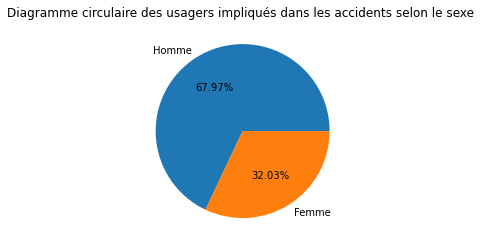

In [20]:
df_sexe.plot.pie(label = "", title = "Diagramme circulaire des usagers impliqués dans les accidents selon le sexe ", autopct='%1.2f%%')

Les usagers impliqués dans les accidents de la route en 2019 sont à 68% des hommes. 

In [21]:
df_utiles["grav"].mean()

0.02630530091669988

2,6% des usagers impliquées dans un accident sont mortes en 2019.

In [22]:
df_utiles["vma"].describe()

count    132977.000000
mean         61.545861
std          25.020834
min          -1.000000
25%          50.000000
50%          50.000000
75%          80.000000
max         800.000000
Name: vma, dtype: float64

## Partie descriptive

#### Analyse statistique des données de df_utiles.csv : matrice des corrélations 


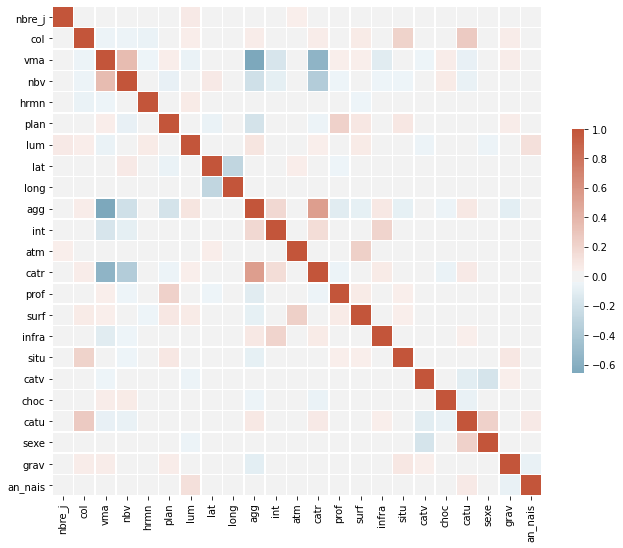

In [23]:
variables_observees = ['nbre_j','col','vma', 'nbv', 'hrmn','plan', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'choc', 'catu', 'sexe', 'grav', 'an_nais']

correl = df_utiles[variables_observees].corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correl, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

on observe par exemple que la vitesse maximale autorisée sur le lieu et au moment de l’accident (vma) est postivement corrélée au nombre total de voies de circulation (nbv)

**Test des séries temporelles ARIMA pour anticiper le nombre d'accidents**

**But : obtenir la colonne nbre_acc_j qui représente le nombre d'accidents par jour**

In [24]:
nbre_acc_j = df_utiles.groupby(['nbre_j']).agg('count').jour.values #Nbre d'accidents (ou de victimes d'accidents jsp) par jour
ts = pd.Series(nbre_acc_j, index=pd.date_range("1/1/2019", periods=365)) # Objet Series de pandas, pour faire des graphes
ts

2019-01-01    263
2019-01-02    239
2019-01-03    255
2019-01-04    298
2019-01-05    287
             ... 
2019-12-27    272
2019-12-28    309
2019-12-29    262
2019-12-30    266
2019-12-31    270
Freq: D, Length: 365, dtype: int64

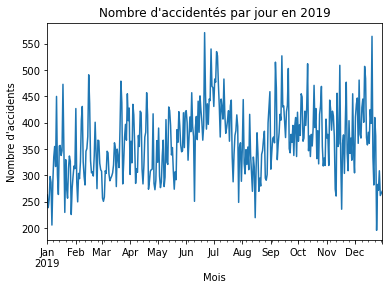

In [25]:
plt.title("Nombre d'accidentés par jour en 2019")
plt.xlabel('Mois')
plt.ylabel("Nombre d'accidents")
ts.plot()

On observe de pics significatifs : le premier vers mi-juin qui pourrait correspondre aux départs massifs en vacances ce qui entraîne inévitablement un plus grand nombre d'accident, et le deuxième vers mi-décembre qui pourrait être lié aux intempéries et à la météo moins favorable en hiver.

#### Graphe d'autocorrélation 

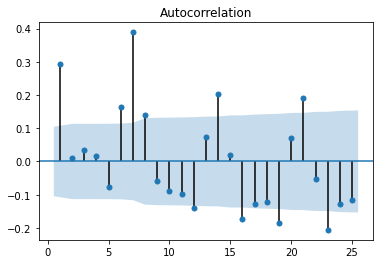

In [26]:
# On retire la moyenne glissante
nbre_acc_j_dataframe = pd.DataFrame(nbre_acc_j)
nbre_acc_rolling = nbre_acc_j_dataframe - nbre_acc_j_dataframe.rolling(15).mean()

# On retire les valeurs NaN
nbre_acc_rolling = nbre_acc_rolling.dropna() 

# On dessine le graphe
fig, ax1 = plt.subplots() 
plot_acf(nbre_acc_rolling, lags=25, zero=False, ax=ax1);

Conclusion : la composante saisonale a pour période 7 (abscisse du max sur le plot ci-dessus)

**SARIMAX : prédire le nombre d'accidents en s'appuyant sur les données déjà enregistrées**

In [27]:
# Création du modèle Sarimax
model = SARIMAX(nbre_acc_j, order=(31, 0, 0), seasonal_order=(1, 1, 0, 32)) # Le 7 correspond à la période déterminée ci-dessus

# Fit du modèle
results = model.fit()

# Affichage du résumé des résultats
results.summary()

D:\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  365
Model:             SARIMAX(31, 0, 0)x(1, 1, 0, 32)   Log Likelihood               -1799.521
Date:                             Thu, 06 Jan 2022   AIC                           3665.042
Time:                                     19:52:50   BIC                           3790.711
Sample:                                          0   HQIC                          3715.154
                                             - 365                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2513      0.064      3.949      0.000       0.127       0.376
ar.L2          0.0997      0.063      1.589      0.112      -0.023       0.223
ar.L3          0.0917      0.068      1.353      0.176      -0.041       0.224
ar.L4          0.0950      0.066      1.448      0.148      -0.034       0.224
ar.L5          0.0278      0.062      0.447      0.655      -0.094       0.150
ar.L6          0.0319      0.063      0.505      0.613      -0.092       0.156
ar.L7          0.3545      0.060      5.892      0.000       0.237       0.472
ar.L8         -0.0017      0.064     -0.026      0.979      -0.127       0.124
ar.L9          0.0194      0.064      0.305      0.761      -0.105       0.144
ar.L10         0.0074      0.068      0.109      0.913      -0.126       0.141
ar.L11        -0.0633      0.066     -0.952      0.341      -0.193       0.067
ar.L12        -0.0742      0.069     -1.082      0.279      -0.209       0.060
ar.L13         0.0678      0.062      1.091      0.275      -0.054       0.190
ar.L14        -0.0075      0.063     -0.119      0.906      -0.131       0.116
ar.L15        -0.0385      0.066     -0.579      0.562      -0.169       0.092
ar.L16        -0.0694      0.064     -1.083      0.279      -0.195       0.056
ar.L17        -0.0514      0.066     -0.775      0.438      -0.181       0.079
ar.L18         0.1220      0.065      1.892      0.059      -0.004       0.248
ar.L19        -0.1309      0.076     -1.733      0.083      -0.279       0.017
ar.L20         0.1133      0.075      1.513      0.130      -0.033       0.260
ar.L21         0.1023      0.067      1.522      0.128      -0.029       0.234
ar.L22        -0.1467      0.072     -2.028      0.043      -0.288      -0.005
ar.L23        -0.1088      0.069     -1.582      0.114      -0.243       0.026
ar.L24         0.1068      0.069      1.540      0.124      -0.029       0.243
ar.L25        -0.0760      0.069     -1.095      0.273      -0.212       0.060
ar.L26         0.0211      0.078      0.272      0.786      -0.131       0.174
ar.L27        -0.0294      0.071     -0.415      0.678      -0.168       0.109
ar.L28         0.1746      0.072      2.428      0.015       0.034       0.316
ar.L29         0.0354      0.068      0.522      0.602      -0.098       0.169
ar.L30         0.0121      0.067      0.179      0.858      -0.120       0.144
ar.L31        -0.2217      0.064     -3.441      0.001      -0.348      -0.095
ar.S.L32      -0.4567      0.064     -7.176      0.000      -0.581      -0.332
sigma2      2758.7861    217.777     12.668      0.000    2331.951    3185.621
===================================================================================
Ljung-Box (Q):                       35.55   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.67   Prob(JB):                         0.12
Heteroskedasticity (H):     

In [28]:
results_pred = results.get_forecast(31) #Utilise le modèle précédent afin de prédire 31 nouvelles valeurs (mois de janvier 2020)
results_mean = results_pred.predicted_mean #Je ne sais pas trop
results_mean = pd.DataFrame(results_mean) #En objet dataframe
results_final = nbre_acc_j_dataframe.append(results_mean) #On adjoint les 31 prédictions aux valeurs réelles afin de tout afficher
results_final = results_final.reset_index() #Après cette fusion de dataframe, l'index est cassé, on le réinitialise donc
results_final = results_final.drop("index", axis=1) #La commande précédent ajoute une colonne "index" inutile dans le DataFrame, on la supprime
date_index = pd.date_range('1/1/2019', periods=396, freq='D') #Pour avoir les dates en abscisse (365 + 31 = 396 jours)
results_final = results_final.set_index(date_index)
print(results_final)

                     0
2019-01-01  263.000000
2019-01-02  239.000000
2019-01-03  255.000000
2019-01-04  298.000000
2019-01-05  287.000000
...                ...
2020-01-27  300.293918
2020-01-28  303.277727
2020-01-29  323.448092
2020-01-30  362.116787
2020-01-31  305.975143

[396 rows x 1 columns]


### Traitement des données de 2020 afin de les comparer à notre prédiction

In [29]:
df_accidents2020 = pd.read_csv('Bases de données/caracteristiques-2020.csv', sep=";")
df_usagers2020 = pd.read_csv('Bases de données/usagers-2020.csv', sep=";")
df_lieux2020 = pd.read_csv('Bases de données/lieux-2020.csv', sep=";")
df_vehicules2020 = pd.read_csv('Bases de données/vehicules-2020.csv', sep=";")
df_merge2020 = df_accidents2020.merge(df_usagers2020.merge(df_lieux2020.merge(df_vehicules2020))) 

In [30]:
df_utiles2020 = df_merge2020.drop(axis=1, labels=['Num_Acc', 'com', 'adr', 'v1', 'id_vehicule', 'num_veh', 'lartpc', 'larrout', 'occutc', 'v2', 'voie'])
df_utiles2020 = df_utiles2020.dropna()

In [31]:
df_utiles2020["hrmn"] = pd.to_datetime(df_utiles2020["hrmn"], format='%H:%S')
df_utiles2020["hrmn"] = df_utiles2020["hrmn"].apply(lambda x: int(x.hour)*60 + int(x.minute))
df_utiles2020["hrmn"] = df_utiles2020["hrmn"].astype('int64')

In [32]:
# la colonne "jour_format_normal" contient la date au format standard dd/mm/yyyy
df_utiles2020["jour_format_normal"] = df_utiles2020["jour"].astype(str)+'/'+df_utiles2020["mois"].astype(str)+'/'+df_utiles2020["an"].astype(str)
df_utiles2020["jour_format_normal"] = pd.to_datetime(df_utiles2020["jour_format_normal"], format="%d/%m/%Y")
df_utiles2020["colonne_soustraction"] = date(df_utiles2020["an"].iloc[0], 1, 1) # Création d'une colonne remplie avec la date du 01/01/2019
df_utiles2020["colonne_soustraction"] = pd.to_datetime(df_utiles2020["colonne_soustraction"]) #Pour transformer en objet date 
df_utiles2020["nbre_j"] = df_utiles2020["jour_format_normal"] - df_utiles2020["colonne_soustraction"] # Permet d'obtenir une colonne contenant, pour chaque accident,
# Le nombre de jours écoulés depuis le 01/01/2019

In [33]:

df_utiles2020["dep"] = df_utiles2020["dep"].replace(["2B"], "999") #On remplace les codes des départements de la Corse par des int
df_utiles2020["dep"] = df_utiles2020["dep"].replace(["2A"], "998")
df_utiles2020["actp"] = df_utiles2020["actp"].replace(["A"], "14") #On remplace les actions du piéton non encodées par des chiffres
df_utiles2020["actp"] = df_utiles2020["actp"].replace(["B"], "15")
df_utiles2020["dep"] = df_utiles2020["dep"].astype('int64')
df_utiles2020["grav"] = df_utiles2020["grav"].apply(lambda x: int(x==2)) # On recode la colonne "grav" : tué = 1, blessé léger/hospitalisé/indemne = 0

In [34]:
df_utiles2020['lat'] = df_utiles2020['lat'].str.replace(',', '.').astype(float)
df_utiles2020['long'] = df_utiles2020['long'].str.replace(',', '.').astype(float)


In [35]:
df_utiles2020['catv'] = df_utiles2020['catv'].apply(func)

In [36]:
df_utiles2020.to_csv('df_utiles2020.csv')

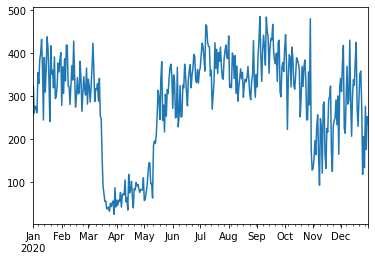

In [38]:
df_utiles2020["nbre_j"] = df_utiles2020["nbre_j"].apply(datification) #Maintenant nbre_j est une colonne d'entiers
nbre_acc_j2020 = df_utiles2020.groupby(['nbre_j']).agg('count').jour.values #Nbre d'accidents (ou de victimes d'accidents jsp) par jour
ts2020 = pd.Series(nbre_acc_j2020, index=pd.date_range("1/1/2020", periods=366)) # Objet Series de pandas, pour faire des graphes
ts2020.plot()

In [41]:
nbre_acc_j_dataframe2020 = pd.DataFrame(nbre_acc_j2020)

remarque sur le confinement en 2020 et la diminution des accidents aux mois de mars,avril,mai,juin

In [43]:
datation = pd.date_range('1/1/2020', periods=366, freq='D')
accident_jour2020 = nbre_acc_j_dataframe2020
accident_jour2020 = accident_jour2020.set_index(datation)
accident_jour2020

,0
2020-01-01,324
2020-01-02,260
2020-01-03,276
2020-01-04,275
2020-01-05,261
...,...
2020-12-27,133
2020-12-28,276
2020-12-29,175
2020-12-30,252


In [44]:
accident_jour2020[0][0:31]

2020-01-01    324
2020-01-02    260
2020-01-03    276
2020-01-04    275
2020-01-05    261
2020-01-06    354
2020-01-07    329
2020-01-08    385
2020-01-09    399
2020-01-10    432
2020-01-11    367
2020-01-12    244
2020-01-13    390
2020-01-14    309
2020-01-15    361
2020-01-16    438
2020-01-17    411
2020-01-18    342
2020-01-19    240
2020-01-20    417
2020-01-21    351
2020-01-22    360
2020-01-23    319
2020-01-24    391
2020-01-25    294
2020-01-26    299
2020-01-27    325
2020-01-28    377
2020-01-29    356
2020-01-30    385
2020-01-31    401
Freq: D, Name: 0, dtype: int64

## Partie carte

# Récupération des frontières des régions françaises

In [ ]:
#Au cas où la cellule suivante ne marche pas
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
fr_regions = pd.read_json('https://france-geojson.gregoiredavid.fr/repo/regions.geojson')
fr_regions = fr_regions.to_json()

 # Les frontières des régions françaises (en geojson) sont stockées dans fr_regions

In [ ]:
coords = (46.539758, 2.430331)
map = folium.Map(location=coords, tiles='OpenStreetMap', zoom_start=6)

In [ ]:
map

pour ajouter des cercles sur la cartes

In [ ]:
for i in range(len(#ACCIDENT)) :
    folium.CircleMarker(location = (LATS[i], LONGS[i]),radius = TEMPS[i]*2,color = 'crimson',fill = True,fill_color = 'crimson').add_to(map)

In [ ]:
pour colorer les cercles colormap

In [ ]:


coords = (46.539758, 2.430331)
map = folium.Map(location=coords, tiles='OpenStreetMap', zoom_start=6)

cm = branca.colormap.LinearColormap(['blue', 'red'], vmin=min(#NB_ACCIDENT), vmax=max(#NB_ACCIDENT))
map.add_child(cm) # add this colormap on the display

for elem1,elem2,.. in zip(var1, var2,..):
    folium.CircleMarker(
        location=[lat, long],
        radius=size,
        color=cm(color),
        fill=True,
        fill_color=cm(color),
        fill_opacity=0.6
    ).add_to(map)

map.save(outfile='map.html')

## Partie prédiction

Virer les lignes redondantes

In [ ]:
variables_utiles_regr = ['an_nais_carre', 'nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'grav', 'an_nais']
variables_utiles_regr_sans_grav = ['an_nais_carre', 'nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'an_nais']
variables_utiles_cat = ['lum', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe']
variables_utiles_num = ['nbre_j', 'hrmn', 'lat', 'long', 'an_nais', 'an_nais_carre']
   
df_keras = df_utiles[variables_utiles_regr] # On ne retient que les variables utiles
df_keras = pd.DataFrame(df_keras)
enc = OneHotEncoder(handle_unknown='ignore') #OneHotEncoder pour les variables catégorielles
ss = StandardScaler() #Permet de rendre les variables numériques centrées et réduites

for var in variables_utiles_cat: # On parcourt les variables utiles catégorielles
    df_keras[var] = enc.fit_transform(df_keras[var].values.reshape(-1, 1)).todense()
pickle.dump(enc, open('onehot.pickle', 'wb')) #Permet de transformer et sauvegarder les entrées en vecteurs encodés de la même manière que les variables catégorielles avec l'Encoder

for var in variables_utiles_num:
    df_keras[var] = ss.fit_transform(df_keras[var].values.reshape(-1, 1))
pickle.dump(ss, open('standardscaler.pickle', 'wb')) #idem que variables catégorielles et l'encodeur

#On chercher à prédire y (grav) à partir des variables explicatives X
X = df_keras[variables_utiles_regr_sans_grav] # Tout le dataframe sans la colonne "grav" qu'on cherche à prédire
y = df_keras.grav #colonne "grav"
y = y.astype(int) #Pour s'assurer que y est une colonne d'int
y = label_binarize(y, classes=[0, 1]) #Pour faire du one-hot encoding sur y
y = pd.DataFrame(y) #car y est devenu un np.array 

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) #K-Fold répété, augmente la précision de l'algo de ~10 %

os = SMOTE(sampling_strategy=0.1) # Pour rééqulibrer l'échantillon (2,63 % d'accidents mortels), crée artificiellement des données
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', os), ('u', under)]
pipeline = Pipeline(steps=steps)
# Appliquer la pipeline précédente aux données
columns = X.columns
X, y = pipeline.fit_resample(X, y)
X = pd.DataFrame(data=X,columns=columns)
y= pd.DataFrame(data=y)

for train_index, test_index in cv.split(X): #On remplit X_train, X_test, Y_train et Y_test pour fitter et tester l'algo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
# Réseaux de neurones
    
model = Sequential()  #Création du modèle, neurone à neurone. fonction d'activation "relu " = partie positive (x -> max(x, 0))
model.add(Dense(256, input_dim=21, activation='relu'))  # variables_utiles_regr_sans_grav contient 22 variables #Il y a 256 neurones sur la couche
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu')) #128 neurones sur la deuxième couche
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 
model.add(Flatten())
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=64)
predictions = model.predict(X_test)
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

## On obtient environ 75% de précision avec le réseau de neurones

In [ ]:
def output_NN_Keras(output):
    if output[0][0] > 0.5:
        return 'Décès'
    else:
        return 'Survie'

def NN_Keras(pred):
    pred = np.asarray(pred).astype('float32')
    pred = pd.DataFrame(np.reshape(pred, (1, -1)), columns=[['nbre_j', 'hrmn', 'lat', 'long', 'an_nais', 'lum', 'agg', 'int', 'atm', 'catr', 'prof', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe']])
    pred['an_nais_carre'] = pred['an_nais']*pred['an_nais']
    loaded_enc = pickle.load(open("onehot.pickle", "rb"))
    loaded_ss = pickle.load(open("standardscaler.pickle", "rb"))
    for var in variables_utiles_cat: # On parcourt les variables utiles catégorielles
        pred[var] = np.array(loaded_enc.fit_transform(pred[var].values.reshape(-1, 1)).todense())
    for var in variables_utiles_num: # On parcourt les variables utiles catégorielles
        pred[var] = loaded_ss.fit_transform(pred[var].values.reshape(-1, 1))
    return [accuracy*100, output_NN_Keras(model.predict(pred))]

## On obtient 80 % de précision avec un RandomForestClassifier

# Interface Dash

In [ ]:

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css'] # Feuille CSS externe, pour mettre en forme la dashboard

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

NUMBER_VAR = (
    'nbre_j', 'hrmn', 'lat', 'long', 'an_nais'
) # Liste des variables sur lesquelles on utilise l'algo

app.layout = html.Div(children=[ #Toute l'app est une balise div, qui contient des balises H1, ..., H6 (pour les titres) et des balises Div pour tous les contenus interactifs
    html.H1(children='Prédictions'),
    html.Div([
        dcc.Graph(id="Carte",figure=px.scatter_geo(df_utiles.head(1000), lat="lat", lon="long", geojson=fr_regions))] # Carte affichant les accidents sur une carte de France
    ,style={'columnCount': 1}), 
    html.Div([
        dcc.Graph(id="Prédictions",figure=px.line(results_final, labels={'x': 'jour', 'y': 'nombre d\'accidentés'}))] #Prédictions SARIMAX
    ,style={'columnCount': 1}), 
    html.Div(children='''
        Remplir les variables
    '''),
            html.Div( # Cette balise Div permet d'afficher les inputs sur l'interface Dash, pour qu'on puisse les remplir
    [
        dcc.Input(
            id="input_{}".format(_), # On identifie chaque Input par un ID "input_nomdelavariable", utile pour les callbacks
            type="number",
            placeholder="variable {}".format(_),
        )
        for _ in NUMBER_VAR # On affiche les inputs pour les variables quantitatives (non catégorielles)
    ]),
            html.Div([
    dcc.Dropdown(
        id='lum',
        options=[
            {'label': 'Plein jour', 'value': '1'},
            {'label': 'Crépuscule ou aube', 'value': '2'},
            {'label': 'Nuit sans éclairage public', 'value': '3'},
            {'label': 'Nuit avec éclairage public non allumé', 'value': '4'},
            {'label': 'Nuit avec éclairage public allumé', 'value': '5'}
        ],
        placeholder="Conditions d'éclairage"
    )]),
    
            html.Div([
    dcc.Dropdown(
        id='catv',
        options=[
            {'label': 'Indéterminable/piéton', 'value': '0'},
            {'label': 'Véhicule léger (voiture, utilitaire)', 'value': '1'},
            {'label': 'Sans permis (< 125 cm3) (vélo, scooter, ...)', 'value': '2'},
            {'label': 'Poids lourd', 'value': '3'},
            {'label': 'Transport en commun', 'value': '4'},
            {'label': '> 125 cm3 à 2/3 roues', 'value': '5'}
        ],
        placeholder="Type de véhicule de l'individu"
    )]),
    
    
             html.Div([
    dcc.Dropdown(
        id='agg',
        options=[
            {'label': 'Hors agglomération', 'value': '1'},
            {'label': 'En agglomération', 'value': '2'}
        ],
        placeholder="En agglo ou non"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='int',
        options=[
            {'label': 'Hors intersection', 'value': '1'},
            {'label': 'Intersection en X', 'value': '2'},
            {'label': 'Intersection en T', 'value': '3'},
            {'label': 'Intersection en Y ', 'value': '4'},
            {'label': 'Intersection à plus de 4 branches', 'value': '5'},
            {'label': 'Giratoire', 'value': '6'},
            {'label': 'Place ', 'value': '7'},
            {'label': 'Passage à niveau ', 'value': '8'},
            {'label': 'Autre intersection', 'value': '9'}
        ],
        placeholder="Type d'intersection"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='atm',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Normale', 'value': '1'},
            {'label': 'Pluie légère', 'value': '2'},
            {'label': 'Pluie forte', 'value': '3'},
            {'label': 'Neige - grêle', 'value': '4'},
            {'label': 'Brouillard - fumée', 'value': '5'},
            {'label': 'Vent fort - tempête', 'value' : '6'},
            {'label': 'Temps éblouissant', 'value': '7'},
            {'label': 'Temps couvert', 'value': '8'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Conditions météorologiques au moment de l'accident"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='catr',
        options=[
            {'label': 'Autoroute', 'value': '1'},
            {'label': 'Route nationale', 'value': '2'},
            {'label': 'Route Départementale', 'value': '3'},
            {'label': 'Voie Communales', 'value': '4'},
            {'label': 'Hors réseau public', 'value': '5'},
            {'label': 'Parc de stationnement ouvert à la circulation publique', 'value': '6'},
            {'label': 'Routes de métropole urbaine', 'value': '7'},
            {'label': 'autre', 'value': '9'}
        ],
        placeholder="Type de route"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='prof',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Plat', 'value': '1'},
            {'label': 'Pente', 'value': '2'},
            {'label': 'Sommet de côte', 'value': '3'},
            {'label': 'Bas de côte', 'value': '4'}
        ],
        placeholder="Profil (déclivité)"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='surf',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Normale', 'value': '1'},
            {'label': 'Mouillée', 'value': '2'},
            {'label': 'Flaques', 'value': '3'},
            {'label': 'Inondée', 'value': '4'},
            {'label': 'Enneigée', 'value': '5'},
            {'label': 'Boue', 'value' : '6'},
            {'label': 'Verglacée', 'value': '7'},
            {'label': 'Corps gras - huile', 'value': '8'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Surface de la chaussée"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='infra',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Souterrain - tunnel', 'value': '1'},
            {'label': 'Pont - autopont', 'value': '2'},
            {'label': 'Bretelle d’échangeur ou de raccordement', 'value': '3'},
            {'label': 'Voie ferrée', 'value': '4'},
            {'label': 'Carrefour aménagé', 'value': '5'},
            {'label': 'Zone piétonne', 'value' : '6'},
            {'label': 'Zone de péage', 'value': '7'},
            {'label': 'Chantier', 'value': '8'},
            {'label': 'Autres', 'value': '9'}
        ],
        placeholder="Type d'infrastructures/aménagement"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='situ',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Sur chaussée', 'value': '1'},
            {'label': 'Sur bande d’arrêt d’urgence', 'value': '2'},
            {'label': 'Sur accotement', 'value': '3'},
            {'label': 'Sur trottoir', 'value': '4'},
            {'label': 'Sur piste cyclable', 'value': '5'},
            {'label': 'Sur autre voie spéciale', 'value' : '6'},
            {'label': 'Autres', 'value': '8'}
        ],
        placeholder="Situation de l'accident"
    )]),
             html.Div([
    dcc.Dropdown(
        id='obs',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Sans objet', 'value': '0'},
            {'label': 'Véhicule en stationnement', 'value': '1'},
            {'label': 'Arbre', 'value': '2'},
            {'label': 'Glissière métallique', 'value': '3'},
            {'label': 'Glissière béton', 'value': '4'},
            {'label': 'Autre glissière', 'value': '5'},
            {'label': 'Bâtiment, mur, pile de pont', 'value' : '6'},
            {'label': 'Support de signalisation verticale ou poste d’appel d’urgence', 'value': '7'},
            {'label': 'Poteau', 'value': '8'},
            {'label': 'Mobilier urbain', 'value': '9'},
            {'label': 'Parapet', 'value': '10'},
            {'label': 'Ilot, refuge, borne haute', 'value': '11'},
            {'label': 'Bordure de trottoir', 'value': '12'},
            {'label': 'Fossé, talus, paroi rocheuse', 'value': '13'},
            {'label': 'Autre obstacle fixe sur chaussée', 'value': '14'},
            {'label': 'Autre obstacle fixe sur trottoir ou accotement', 'value': '15'},
            {'label': 'Sortie de chaussée sans obstacle', 'value': '16'},
            {'label': 'Buse – tête d’aqueduc', 'value': '17'}
        ],
        placeholder="Obstacle fixe percuté"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='obsm',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Piéton', 'value': '1'},
            {'label': 'Véhicule', 'value': '2'},
            {'label': 'Véhicule sur rail', 'value': '4'},
            {'label': 'Animal domestique', 'value': '5'},
            {'label': 'Animal sauvage', 'value' : '6'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Obstacle mobile percuté"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='choc',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Avant', 'value': '1'},
            {'label': 'Avant droit', 'value': '2'},
            {'label': 'Avant gauche', 'value': '3'},
            {'label': 'Arrière', 'value': '4'},
            {'label': 'Arrière droit', 'value': '5'},
            {'label': 'Arrière gauche', 'value' : '6'},
            {'label': 'Côté droit', 'value': '7'},
            {'label': 'Côté gauche', 'value': '8'},
            {'label': 'Chocs multiples (tonneaux)', 'value': '9'}
        ],
        placeholder="Point de choc initial"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='catu',
        options=[
            {'label': 'Conducteur', 'value': '1'},
            {'label': 'Passager', 'value': '2'},
            {'label': 'Piéton', 'value': '3'}
        ],
        placeholder="L'individu est..."
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='sexe',
        options=[
            {'label': 'Masculin', 'value': '1'},
            {'label': 'Féminin', 'value': '2'}
        ],
        placeholder="Sexe de l'individu"
    )]),
    html.Div(id="out-all-types")
])

@app.callback(
     Output("out-all-types", "children"),
     [Input("input_{}".format(_), "value") for _ in NUMBER_VAR], # On lie les inputs affichés sur Dash et la fonction cb_render
     Input("lum", "value"),
     Input("agg", "value"),
     Input("int", "value"),
     Input("atm", "value"),
     Input("catr", "value"),
     Input("prof", "value"),
     Input("surf", "value"),
     Input("infra", "value"),
     Input("situ", "value"),
     Input("catv", "value"),
     Input("obs", "value"),
     Input("obsm", "value"),
     Input("choc", "value"),
     Input("catu", "value"),
     Input("sexe", "value"),
)
def cb_render(*vals):
    if not None in vals:
        float_vals = []
        for item in vals:
            float_vals.append(float(item))
        res = NN_Keras(vals)
        return "L'algorithme prédit : {}, avec une précision de {}".format(res[1], res[0]) 

if __name__ == '__main__':
    app.run_server(host='127.0.0.1', port='8050')